In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Load training and validation datasets
training_set = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),  # Changed to 224x224 for VGG16 compatibility
    shuffle=True
)

Found 70295 files belonging to 38 classes.


In [3]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)

Found 17572 files belonging to 38 classes.


In [4]:
# Class names
class_names = training_set.class_names
num_classes = len(class_names)

In [5]:
# Load pre-trained VGG16 model (excluding fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [6]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False


In [7]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces dimensions
x = Dense(1500, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer


In [8]:

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)


In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Train the model
training_history = model.fit(training_set, validation_data=validation_set, epochs=10)


Epoch 1/10
2197/2197 [==============================] - 480s 212ms/step - loss: 0.7743 - accuracy: 0.7901 - val_loss: 0.2041 - val_accuracy: 0.9405
Epoch 2/10
2197/2197 [==============================] - 476s 216ms/step - loss: 0.2355 - accuracy: 0.9245 - val_loss: 0.1437 - val_accuracy: 0.9558
Epoch 3/10
2197/2197 [==============================] - 495s 225ms/step - loss: 0.1616 - accuracy: 0.9470 - val_loss: 0.1237 - val_accuracy: 0.9608
Epoch 4/10
2197/2197 [==============================] - 497s 226ms/step - loss: 0.1217 - accuracy: 0.9598 - val_loss: 0.1111 - val_accuracy: 0.9648
Epoch 5/10
2197/2197 [==============================] - 494s 225ms/step - loss: 0.0974 - accuracy: 0.9678 - val_loss: 0.0967 - val_accuracy: 0.9673
Epoch 6/10
2197/2197 [==============================] - 529s 241ms/step - loss: 0.0794 - accuracy: 0.9735 - val_loss: 0.0873 - val_accuracy: 0.9715
Epoch 7/10
2197/2197 [==============================] - 533s 243ms/step - loss: 0.0661 - accuracy: 0.9778 - val_

In [13]:
# Model evaluation
train_loss, train_acc = model.evaluate(training_set)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_acc}")

2197/2197 [==============================] - 275s 125ms/step - loss: 0.0189 - accuracy: 0.9953
Training Loss: 0.018939359113574028, Training Accuracy: 0.9953054785728455


In [14]:
val_loss, val_acc = model.evaluate(validation_set)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


550/550 [==============================] - 69s 125ms/step - loss: 0.0762 - accuracy: 0.9752
Validation Loss: 0.07622618228197098, Validation Accuracy: 0.9751877784729004


In [15]:
# Save model
model.save("plant_disease_vgg16.keras")


In [16]:
# Save training history
import json
with open("vgg16_training_hist.json", "w") as f:
    json.dump(training_history.history, f)


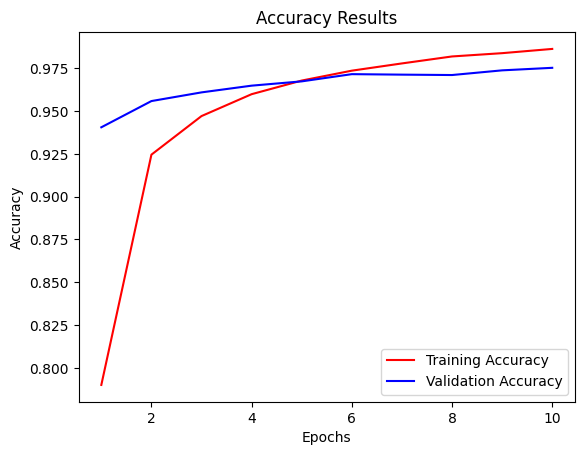

In [17]:
# Plot training vs validation accuracy
epochs = range(1, 11)
plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Results")
plt.legend()
plt.show()


In [18]:
# Load test set for predictions
test_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)

Found 17572 files belonging to 38 classes.


In [19]:
# Predict on test data
y_pred = model.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)


550/550 [==============================] - 68s 123ms/step


In [20]:
# Get true labels
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)


In [21]:
# Classification report
print(classification_report(Y_true, predicted_categories, target_names=class_names))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.99      0.98       504
                                 Apple___Black_rot       1.00      0.99      0.99       497
                          Apple___Cedar_apple_rust       1.00      0.99      0.99       440
                                   Apple___healthy       0.98      0.98      0.98       502
                               Blueberry___healthy       0.99      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       0.99      1.00      0.99       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.89      0.93       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.91      0.99      0.

In [22]:
# Confusion matrix
cm = confusion_matrix(Y_true, predicted_categories)


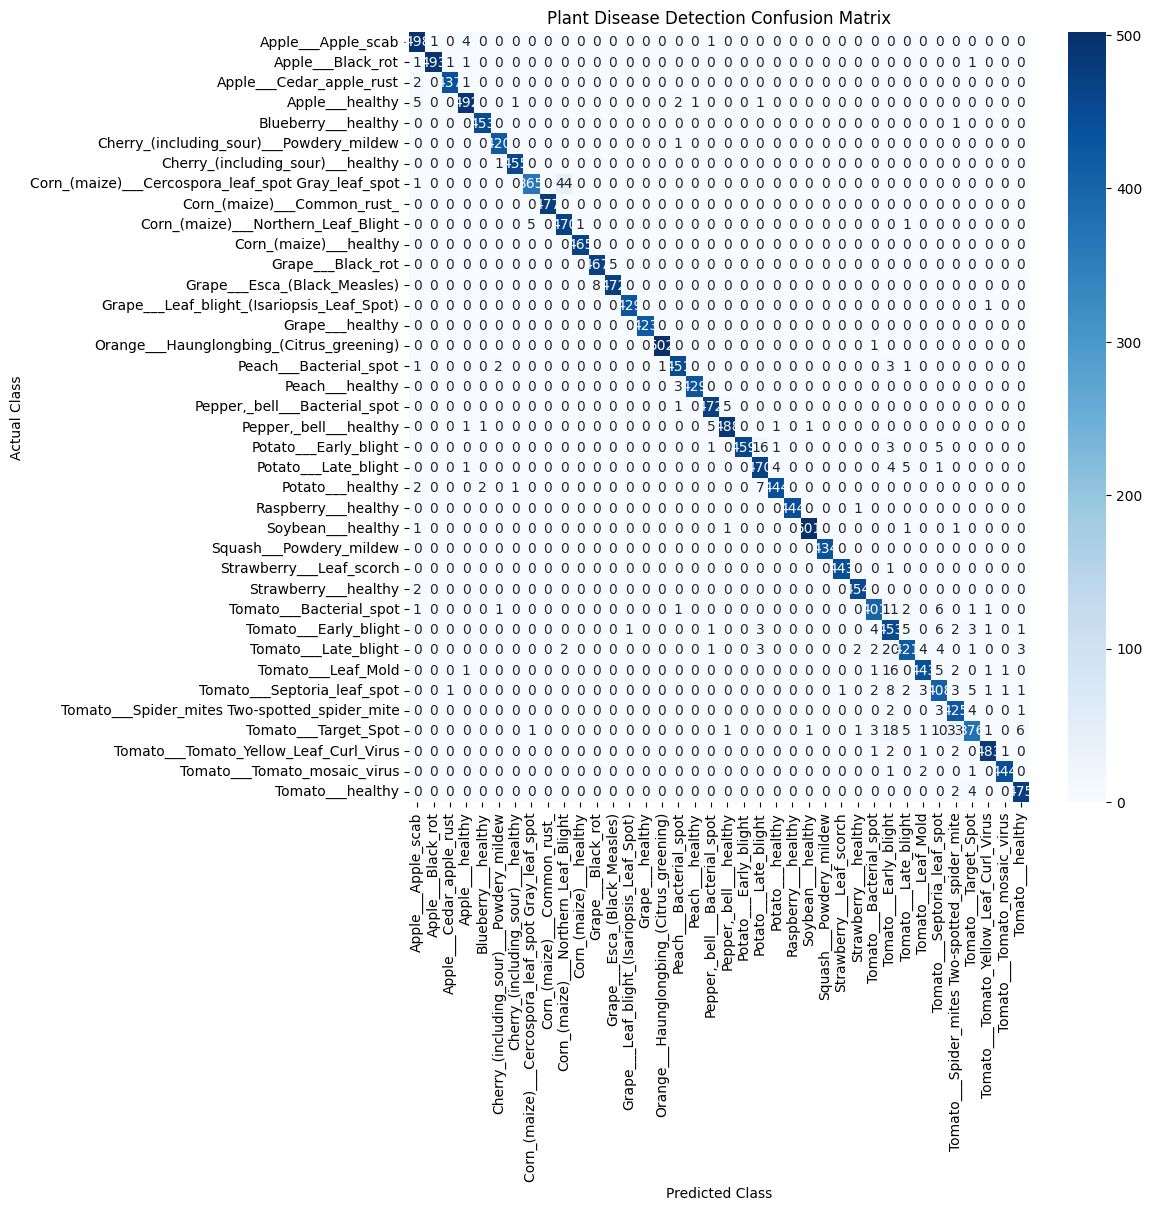

In [23]:
# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Plant Disease Detection Confusion Matrix")
plt.show()